# Notebook for Embeddings

## Imports and parameter settings

In [ ]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from loguru import logger

from typing import List, Optional

# sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# clustering models
from models.cluster import ClusterModel
from models.cluster import KMeansClusterModel, DBSCANClusterModel, HierarchicalClusterModel

# utilities
from utils.load import load_embeddings_dataset
from utils.tf_idf import tfidf_cluster_summary
from utils.metrics import column_wise_summary
# from utils.metrics import davies_bouldin_score, silhouette_score


# -------- plot settings ----------

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # --- Figure ---
    "figure.figsize": (6, 4),
    "figure.dpi": 300,

    # --- Fonts ---
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "font.family": "serif",       # or "sans-serif"
    "mathtext.fontset": "stix",   # clean math font

    # --- Axes ---
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.grid": False,

    # --- Ticks ---
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.major.width": 0.7,
    "ytick.major.width": 0.7,

    # --- Legend ---
    "legend.fontsize": 10,
    "legend.frameon": False,

    # --- Colors / Colormap ---
    "image.cmap": "viridis",
})

# Preprocessing of data

<tt>`embedding_to_array`</tt> to converts the series of embedding into a single stacked 2D array *X*. The <tt>`preprocess_embedding`</tt> function standardizes X, applies Principal Component Analysis (PCA) to reduce its dimensionality while retaining at least 90% of the variance, this is done in order to improve computational efficienciency. The function removes outliers in the new PCA-array using the Interquartile Range (IQR) on each principal component. The function returns the filtered DataFrame and the resulting PCA features.

In [44]:
def embedding_to_array(series: pd.Series) -> np.ndarray:
    """Convert Series of embedding arrays into a stacked ndarray."""
    return np.vstack(series.to_numpy())


def preprocess_embeddings(
    df: pd.DataFrame,
    model_name: str,
    remove_outliers: bool = True,
    iqr_multiplier: float = 4,
):
    """
    Convert embeddings -> standardize -> PCA until ≥90% variance -> optional outlier filtering.

    Output:
        filtered_df, X_pca (2D ndarray)
    """
    df = df.copy()

    # Extract embedding matrix
    X = embedding_to_array(df[model_name])
    logger.info(f"PCA on {model_name} embeddings, original dim={X.shape[1]}")

    # Standardize
    X_scaled = StandardScaler().fit_transform(X)

    # PCA full, then select cutoff at ≥90% explained variance
    pca_full = PCA().fit(X_scaled)
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    k = np.argmax(cum >= 0.90) + 1
    logger.info(f"{model_name}: PCA -> {k} dims (≥90% variance)")

    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)
    # reduce to float32 to save memory
    X_pca = X_pca.astype(np.float32)

    # Optional outlier removal in PCA space
    if remove_outliers:
        mask = np.ones(len(X_pca), dtype=bool)
        for j in range(X_pca.shape[1]):
            q1, q3 = np.percentile(X_pca[:, j], [25, 75])
            iqr = q3 - q1
            lb, ub = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr
            mask &= (X_pca[:, j] >= lb) & (X_pca[:, j] <= ub)

        logger.info(f"Removed {(~mask).sum()} outliers from {model_name} embeddings.")
        return df[mask].reset_index(drop=True), X_pca[mask]

    return df.reset_index(drop=True), X_pca

This code prepares the data by calling <tt>`preprocess_embeddings`</tt> to transform and reduce the dimensionality of the embeddings into a feature array X. It iteratively tests multiple parameter values for K-Means (varying k) and DBSCAN (varying $\epsilon$), calculating the Silhouette Score (for measuring cluster separability) and the Davies-Bouldin Index (for measuring within-cluster similarity and between-cluster differences).

It doesn't run the Hieracial Cluster model as it is very memory and time demanding, running in $O(n^3)$ time. 

[//]: # "Maybe we should mention something about the results for the Hieracial Cluster model if we end up running them?"

In [45]:
def tune_embedding_clusters(
    df: pd.DataFrame,
    model_name: str,
    k_list: Optional[List[int]] = None,
    eps_list: Optional[List[float]] = None,
    n_clusters_list: Optional[List[int]] = None,
    save_path: str = "results/embedding_general",
):
    """
    Unified silhouette-based tuning for KMeans, DBSCAN, Hierarchical.
    Preprocessing done ONCE.

    Args:
        df: DataFrame with embeddings.
        model_name: Embedding column name.
        k_list: List of K values for KMeans.
        eps_list: List of eps values for DBSCAN.
        n_clusters_list: List of n_clusters for Hierarchical.
        save_path: Directory to save tuning results.

    Returns:
        silhouette_scores: Dict of silhouette scores per model and param.
        davies_bouldin_scores: Dict of Davies-Bouldin scores per model and param
    """
    logger.info(f"Preprocessing embeddings for tuning ({model_name})…")
    df_proc, X = preprocess_embeddings(df, model_name)

    silhouette_scores = {
        "kmeans": {},
        "dbscan": {},
        "hierarchical": {}
    }
    davies_bouldin_scores = {
        "kmeans": {},
        "dbscan": {},
        "hierarchical": {}
    }

    # ---- KMeans ----
    if k_list:
        for k in tqdm(k_list, desc=f"[{model_name}] KMeans tuning"):
            # model = KMeansClusterModel(n_clusters=k)
            model = KMeans(n_clusters=k, random_state=42)
            labels = model.fit_predict(X)
            silhouette_scores["kmeans"][k] = silhouette_score(X, labels)
            davies_bouldin_scores["kmeans"][k] = davies_bouldin_score(X, labels)

    # ---- DBSCAN ----
    if eps_list:
        for eps in tqdm(eps_list, desc=f"[{model_name}] DBSCAN tuning"):
            model = DBSCANClusterModel(eps=eps, min_samples=5)
            model.fit(X)
            labels = model.labels_

        if len(set(labels)) > 1 and -1 not in labels:
            silhouette_scores["dbscan"][eps] = silhouette_score(X, labels)
            davies_bouldin_scores["dbscan"][eps] = davies_bouldin_score(X, labels)
        else:
            score = -1  # invalid
        silhouette_scores["dbscan"][eps] = score
        davies_bouldin_scores["dbscan"][eps] = None  # invalid

    # ---- Hierarchical ----
    # NOTE: commented out for speed; uncomment to enable
    # for n in tqdm(n_clusters_list, desc=f"[{model_name}] Hierarchical tuning"):
    #     model = HierarchicalClusterModel(n_clusters=n)
    #     labels = model.fit_predict(X)
    #     results["hierarchical"][n] = silhouette_score(X, labels)

    score_path = f"{save_path}/json/{model_name}_tuning_scores.json"
    with open(score_path, "w") as f:
        json.dump({
            "silhouette": silhouette_scores,
            "davies_bouldin": davies_bouldin_scores
        }, f, indent=2, default=float)

    return silhouette_scores, davies_bouldin_scores


# Plotting
Gets the feature array X from <tt>`preprocess_embeddings`</tt>. It applies the provided ClusterModel to _X_ to generate cluster labels, which are added to the DataFrame. It generates a scatter plot of the data points.

In [46]:
def plot_embedding_clusters(
    df: pd.DataFrame,
    model_name: str,
    model: ClusterModel,
    dim: int = 2,
    remove_outliers: bool = True,
):
    """
    Preprocess -> cluster -> plot (2D or 3D PCA).
    """
    save_dir = "results/embedding_general/plots"

    if dim not in (2, 3):
        raise ValueError("dim must be 2 or 3")

    df_proc, X = preprocess_embeddings(df, model_name, remove_outliers)
    labels = model.fit_predict(X)
    df_proc["cluster_label"] = labels

    # 2D plot
    if dim == 2:
        plt.figure(figsize=(10, 7))
        s = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="tab10", alpha=0.7)
        plt.title(f"{model_name}: 2D PCA clusters")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.tight_layout()
        save_path = f"{save_dir}/{model_name}_2D_clusters.png"
        plt.savefig(save_path, dpi=300)
        return df_proc

    # 3D plot
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection="3d")
    s = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap="tab10", alpha=0.7)
    ax.set_title(f"{model_name}: 3D PCA clusters")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.tight_layout()
    save_path = f"{save_dir}/{model_name}_3D_clusters.png"
    plt.savefig(save_path, dpi=300)
    return df_proc


Preprocessing the embedding data into features _X_ and applying the clustering model to assign a cluster_label to each row. It TF-IDF (Term Frequency-Inverse Document Frequency) to identify the top 10 most distinguishing terms for each cluster.

In [47]:
def evaluate_embedding_metadata(
    df: pd.DataFrame,
    model_name: str,
    model: ClusterModel,
    save_dir: str = "results/embedding_general/json/",
):
    """
    Preprocess -> cluster -> TF-IDF global + per-column.
    Saves:
      - {model_name}_{clusterer}_tfidf_summary.json
      - {model_name}_{clusterer}_tfidf_columns.json
    """
    df_proc, X = preprocess_embeddings(df, model_name)
    df_proc["cluster_label"] = model.fit_predict(X)

    global_path = f"{save_dir}/{model_name}_tfidf_global.json"

    tfidf_cluster_summary(
        df_proc,
        save_path=global_path,
        k=10,
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.8,
    )

    column_path = f"{save_dir}/{model_name}_column_summary.json"

    column_wise_summary(
        df_proc,
        columns=["name", "themes", "keywords", "involved_companies", "first_release_year"],
        save_path=column_path
    )


    return df_proc

# Driver code
The <tt>tuning_pipeline_driver</tt> function loads the embedding dataset and then calls <tt> tune_embedding_clusters </tt> to evaluate a predefined range of hyperparameters to find the best clustering configuration.

In [48]:
def tuning_pipeline_driver():
    """
    Driver code for tuning embedding clustering models.
    """
    embeddings_df = load_embeddings_dataset("data/videogame_embeddings/embedding_dataset.parquet")

    models = ['ast', 'clap', 'wavlm']
    n_clusters = [10]
    eps = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5, 10]
    k_list = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20]
    for model_name in models:
        logger.info(f"Tuning clustering for {model_name} embeddings…")
        tuning_results = tune_embedding_clusters(
            embeddings_df,
            model_name=model_name,
            k_list=k_list
        )
        logger.info(f"Tuning results for {model_name}: {tuning_results}")


def plotting_pipeline_driver():
    """
    Driver code for plotting embedding clustering results.
    """
    embeddings_df = load_embeddings_dataset("data/videogame_embeddings/embedding_dataset.parquet")

    model_names = ['ast', 'clap', 'wavlm']

    for model_name in model_names:
        k = 10
        # model = KMeansClusterModel(n_clusters=k)
        model = KMeans(n_clusters=k, random_state=42)

        logger.info(f"Plotting clustering for {model_name} embeddings with K={k}…")
        clustered_df = plot_embedding_clusters(
            embeddings_df,
            model_name=model_name,
            model=model,
            dim=2
        )
        logger.info(f"Clustered DataFrame head:\n{clustered_df.head()}")

def metadata_evaluation_driver():
    """
    Driver code for evaluating embedding clustering with TF-IDF metadata summaries.
    """

    embeddings_df = load_embeddings_dataset("data/videogame_embeddings/embedding_dataset.parquet")
    k = 10

    # model = KMeansClusterModel(n_clusters=k)
    model = KMeans(n_clusters=k, random_state=42)
    model_names = ['ast', 'clap', 'wavlm']
    
    for model_name in model_names:
        logger.info(f"Evaluating metadata for {model_name} embeddings with K={k}…")
        evaluated_df = evaluate_embedding_metadata(
            embeddings_df,
            model_name=model_name,
            model=model
        )
        logger.info(f"Evaluated DataFrame head:\n{evaluated_df.head()}")


2025-12-02 18:48:49.743 | INFO     | __main__:tuning_pipeline_driver:12 - Tuning clustering for ast embeddings…
2025-12-02 18:48:49.744 | INFO     | __main__:tune_embedding_clusters:25 - Preprocessing embeddings for tuning (ast)…
2025-12-02 18:48:49.756 | INFO     | __main__:preprocess_embeddings:22 - PCA on ast embeddings, original dim=1536
2025-12-02 18:48:50.915 | INFO     | __main__:preprocess_embeddings:31 - ast: PCA -> 408 dims (≥90% variance)
2025-12-02 18:48:51.424 | INFO     | __main__:preprocess_embeddings:47 - Removed 14 outliers from ast embeddings.
[ast] KMeans tuning: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]
2025-12-02 18:48:56.371 | INFO     | __main__:tuning_pipeline_driver:18 - Tuning results for ast: ({'kmeans': {2: 0.082062796, 3: 0.063523024, 4: 0.043903384, 5: 0.050872583, 6: 0.05771035, 8: 0.06141055, 10: 0.05982589, 12: 0.05337317, 15: 0.05138439, 20: 0.04926539}, 'dbscan': {}, 'hierarchical': {}}, {'kmeans': {2: 3.2838230418194425, 3: 3.493609969323217, 4

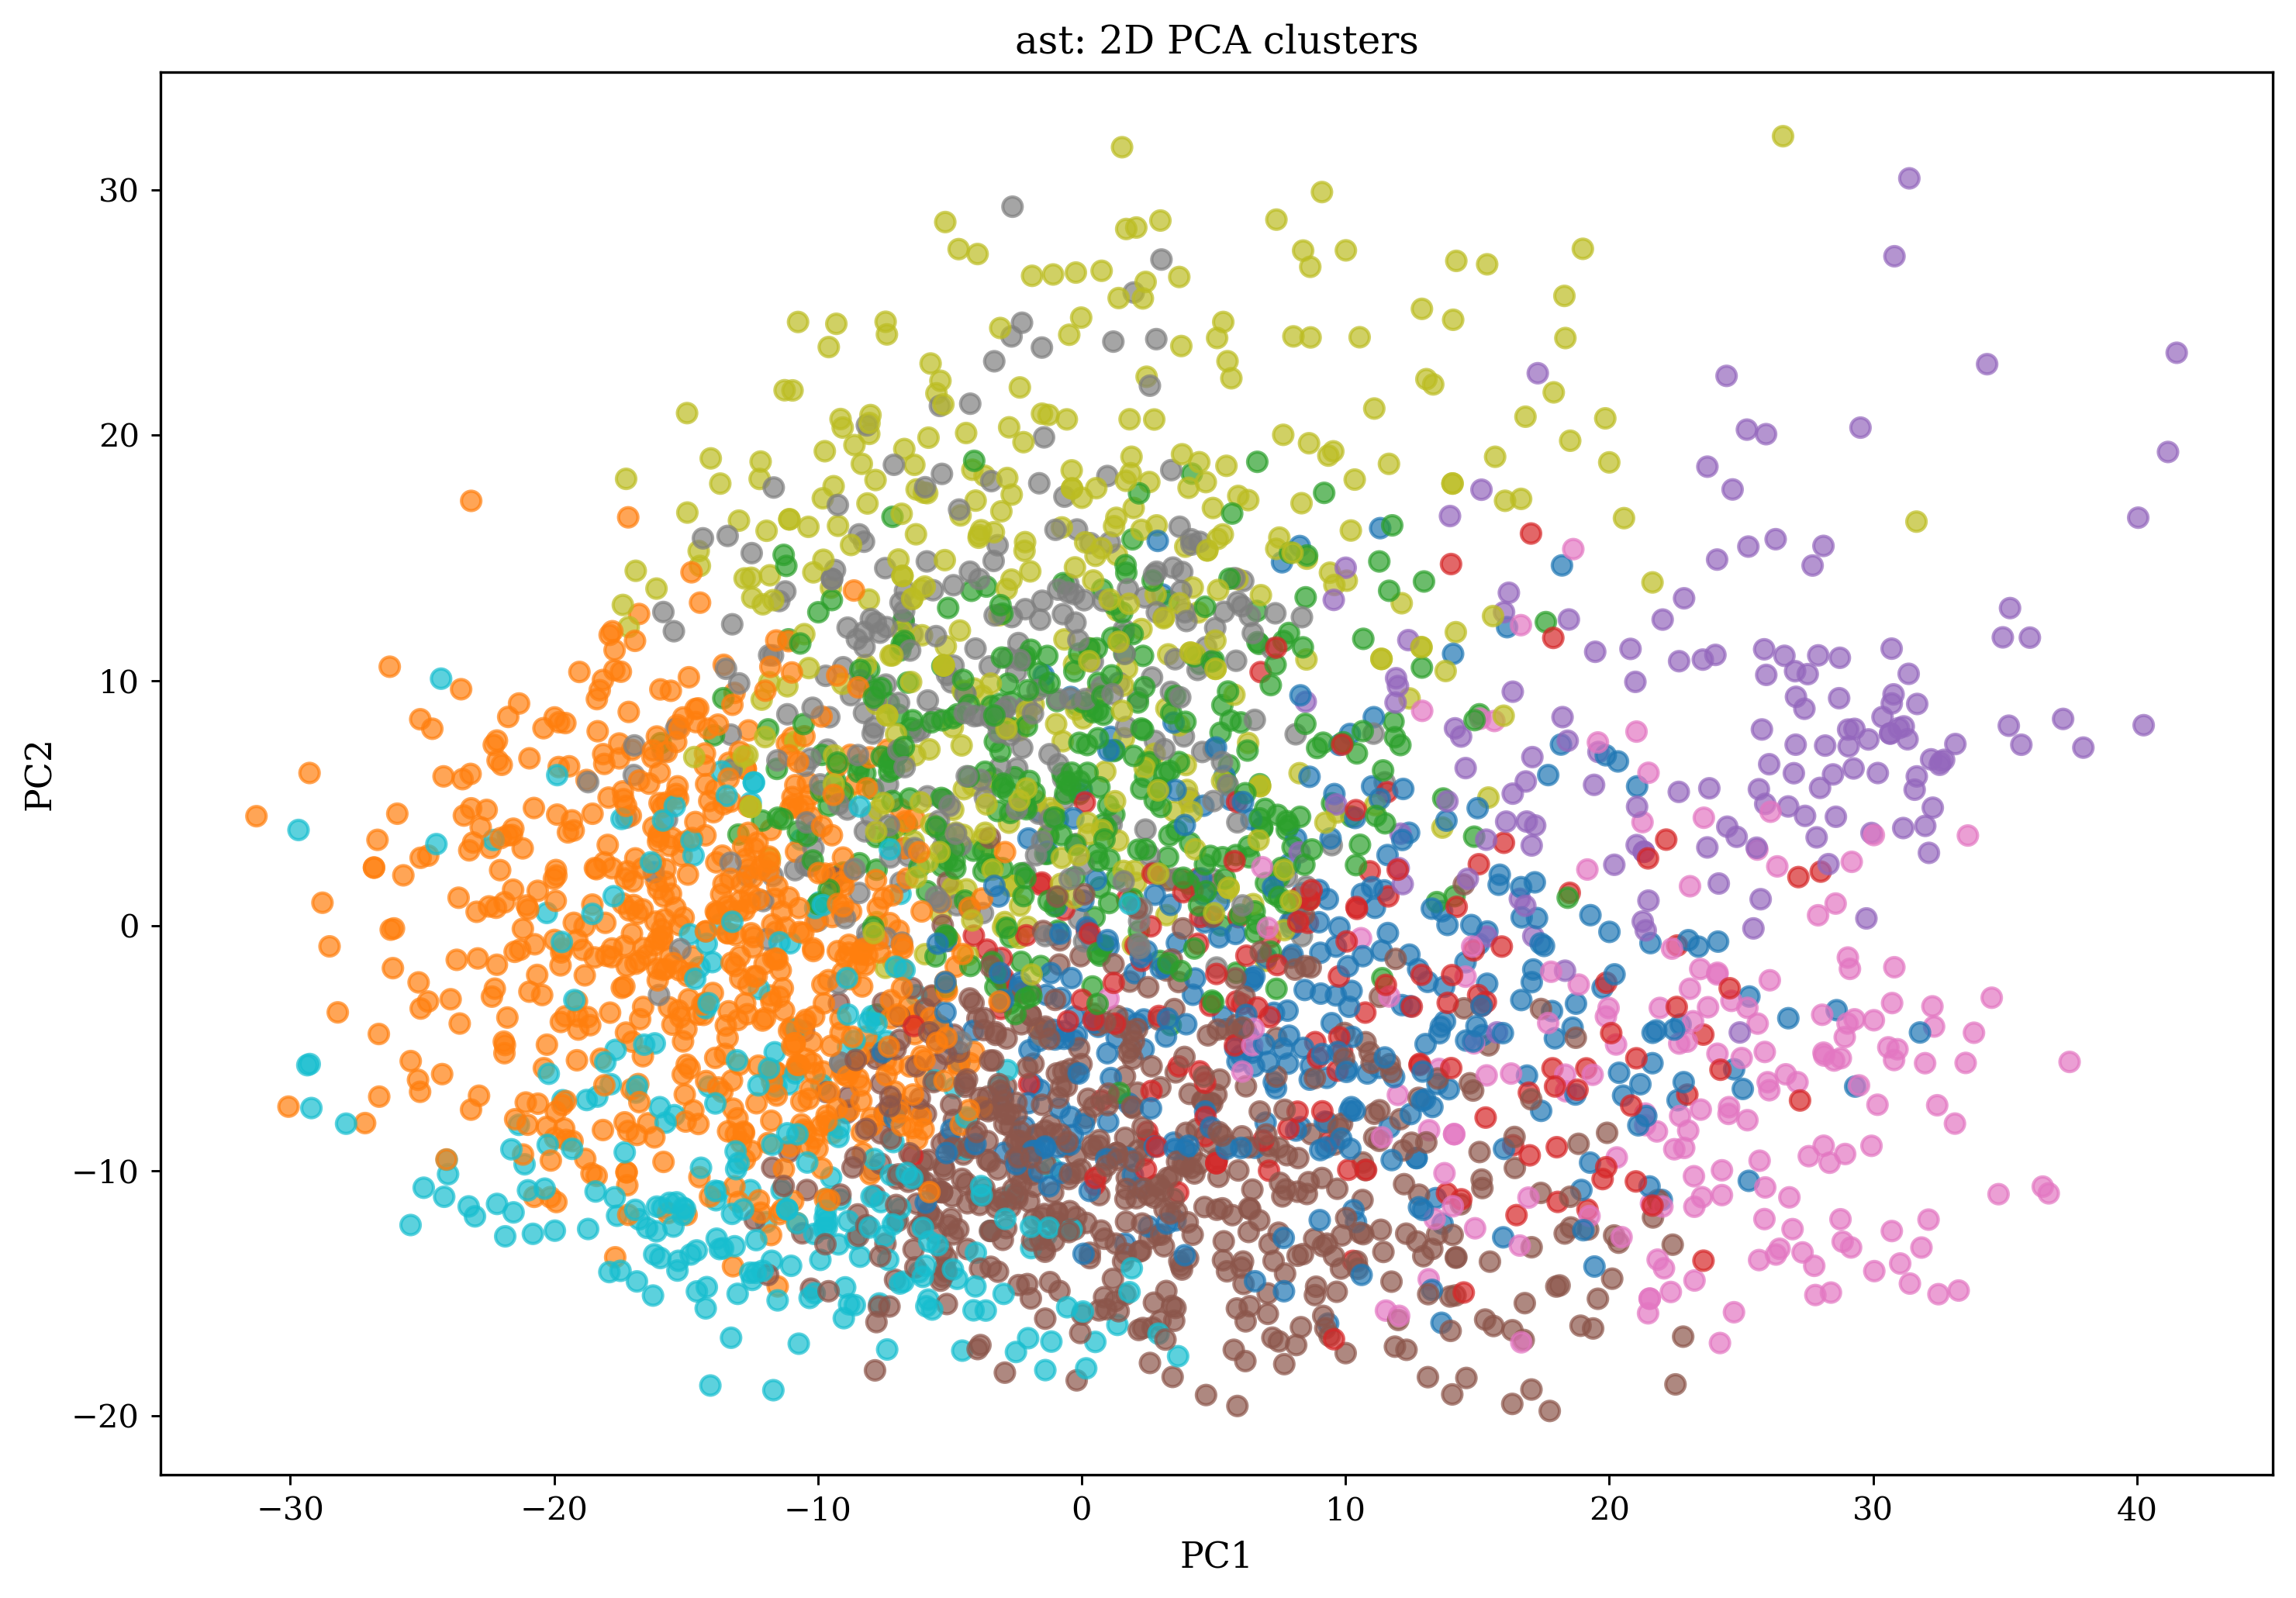

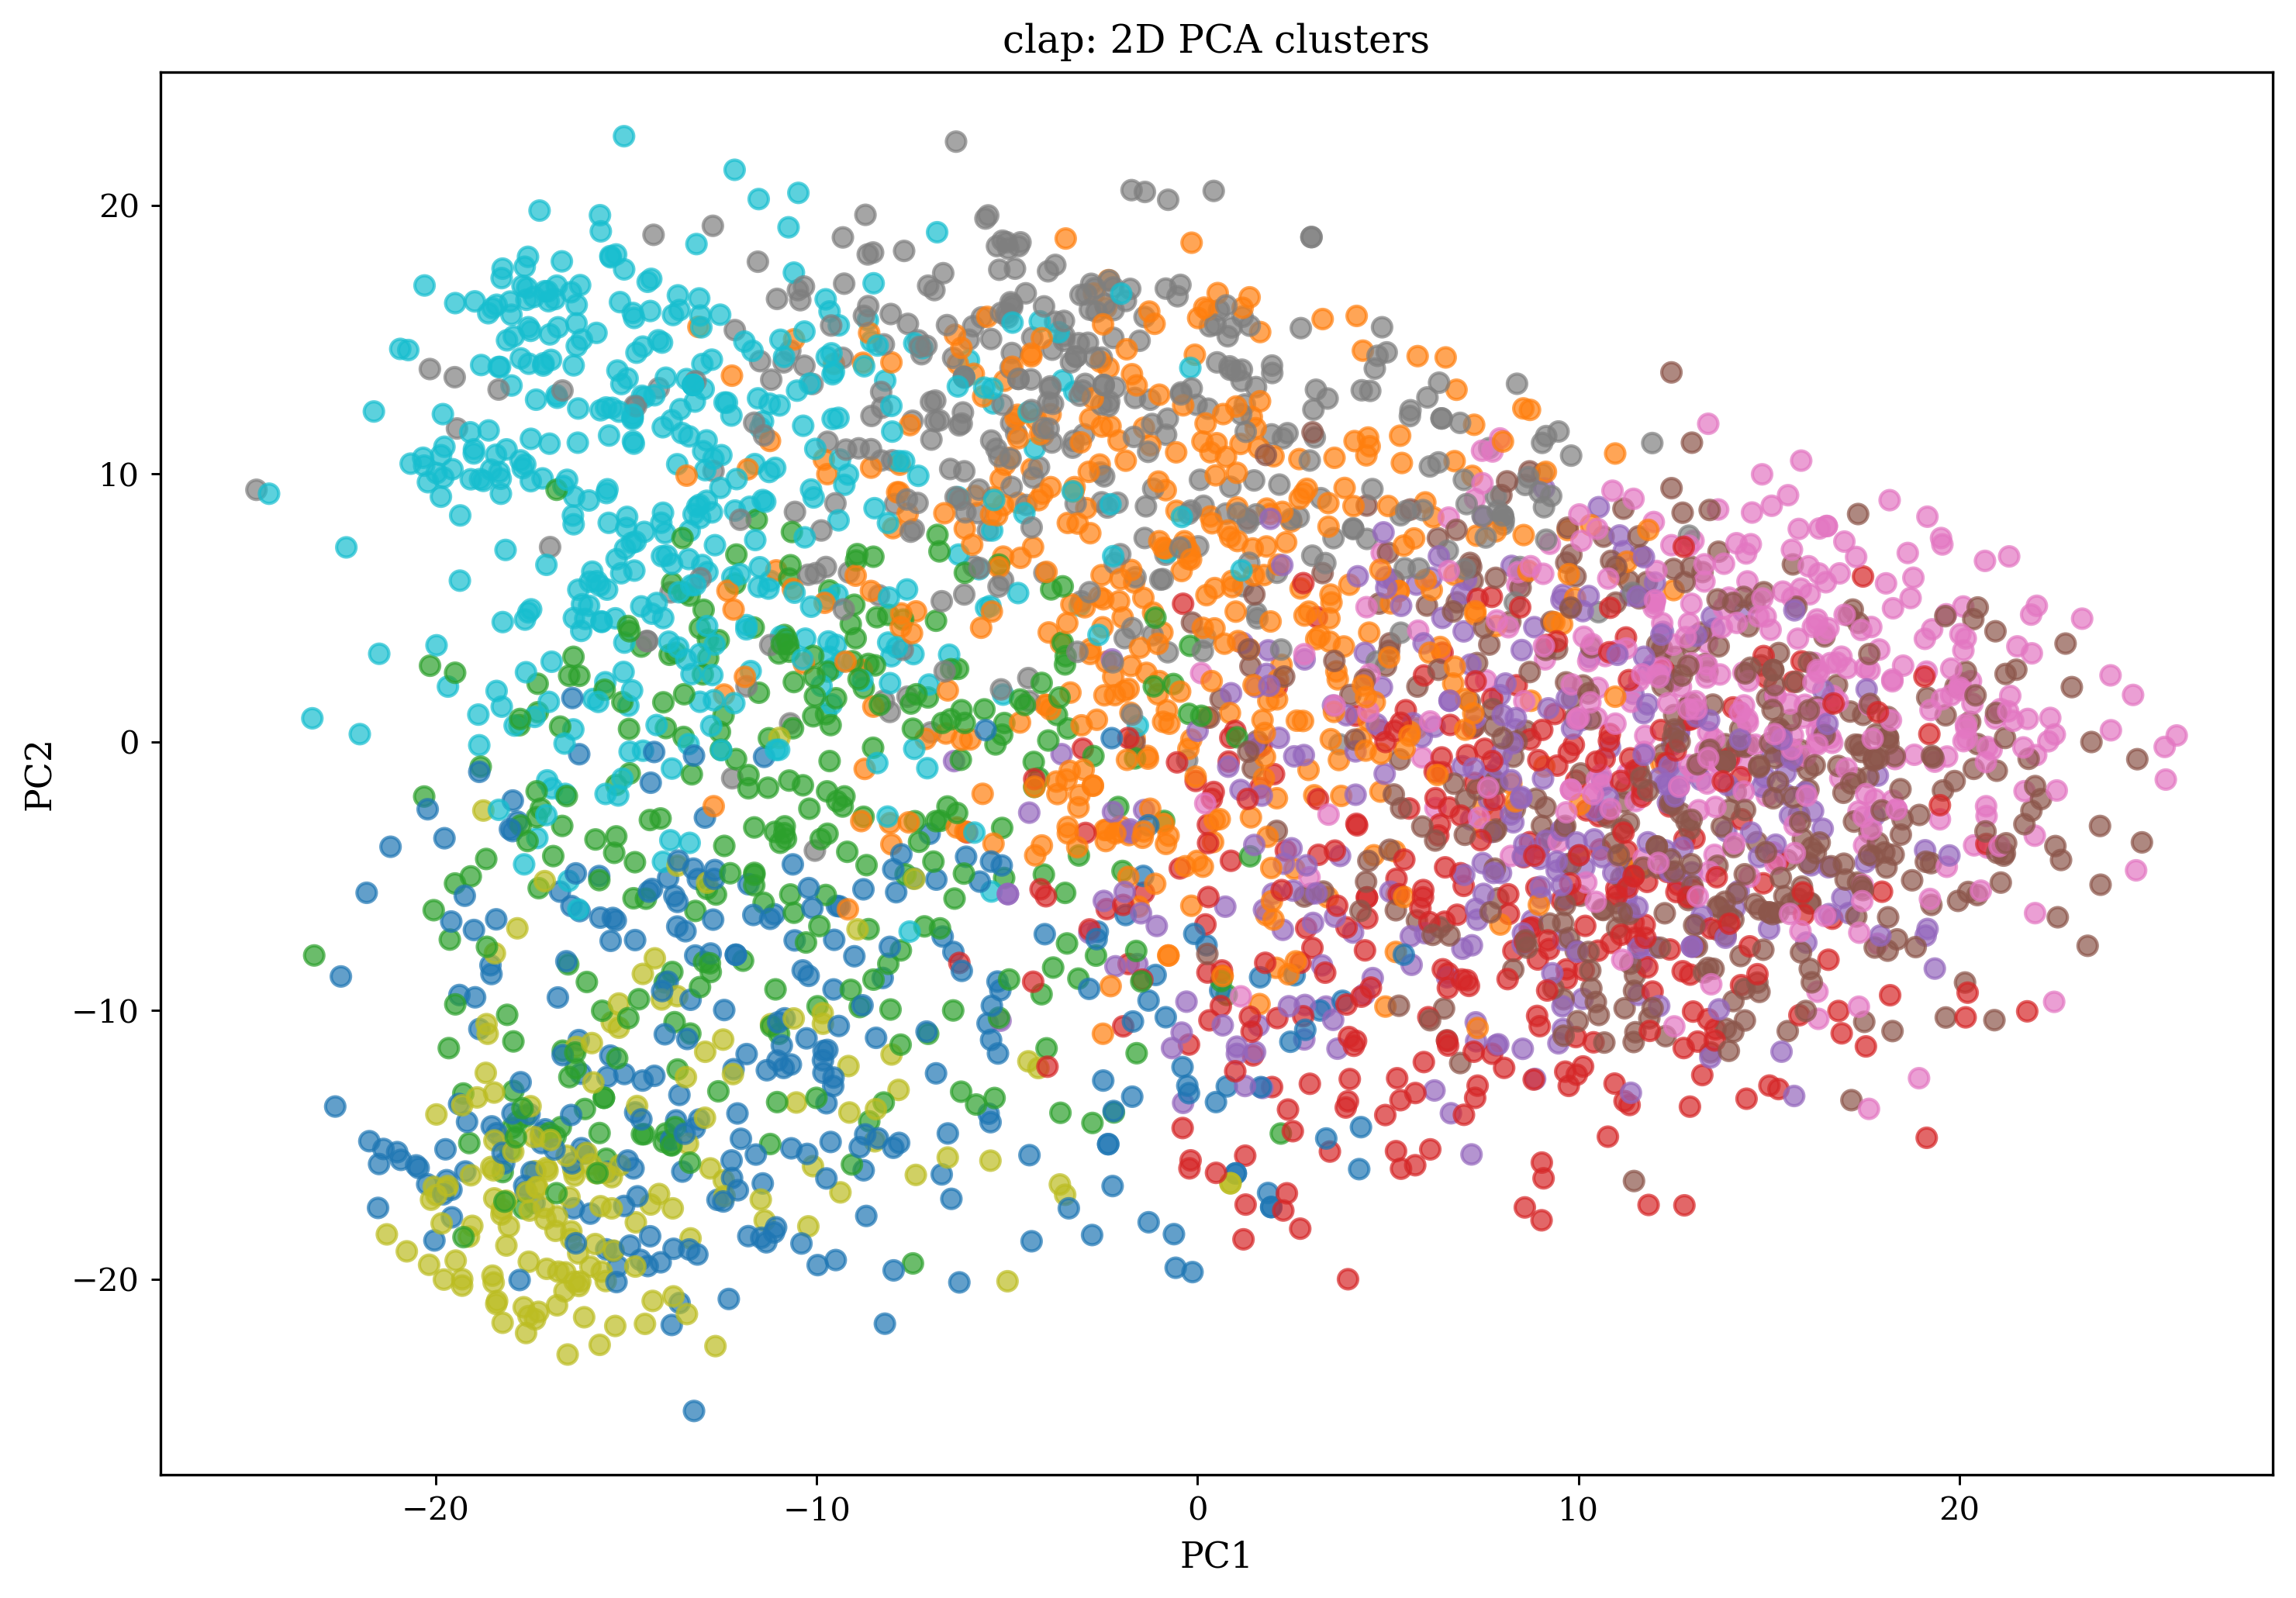

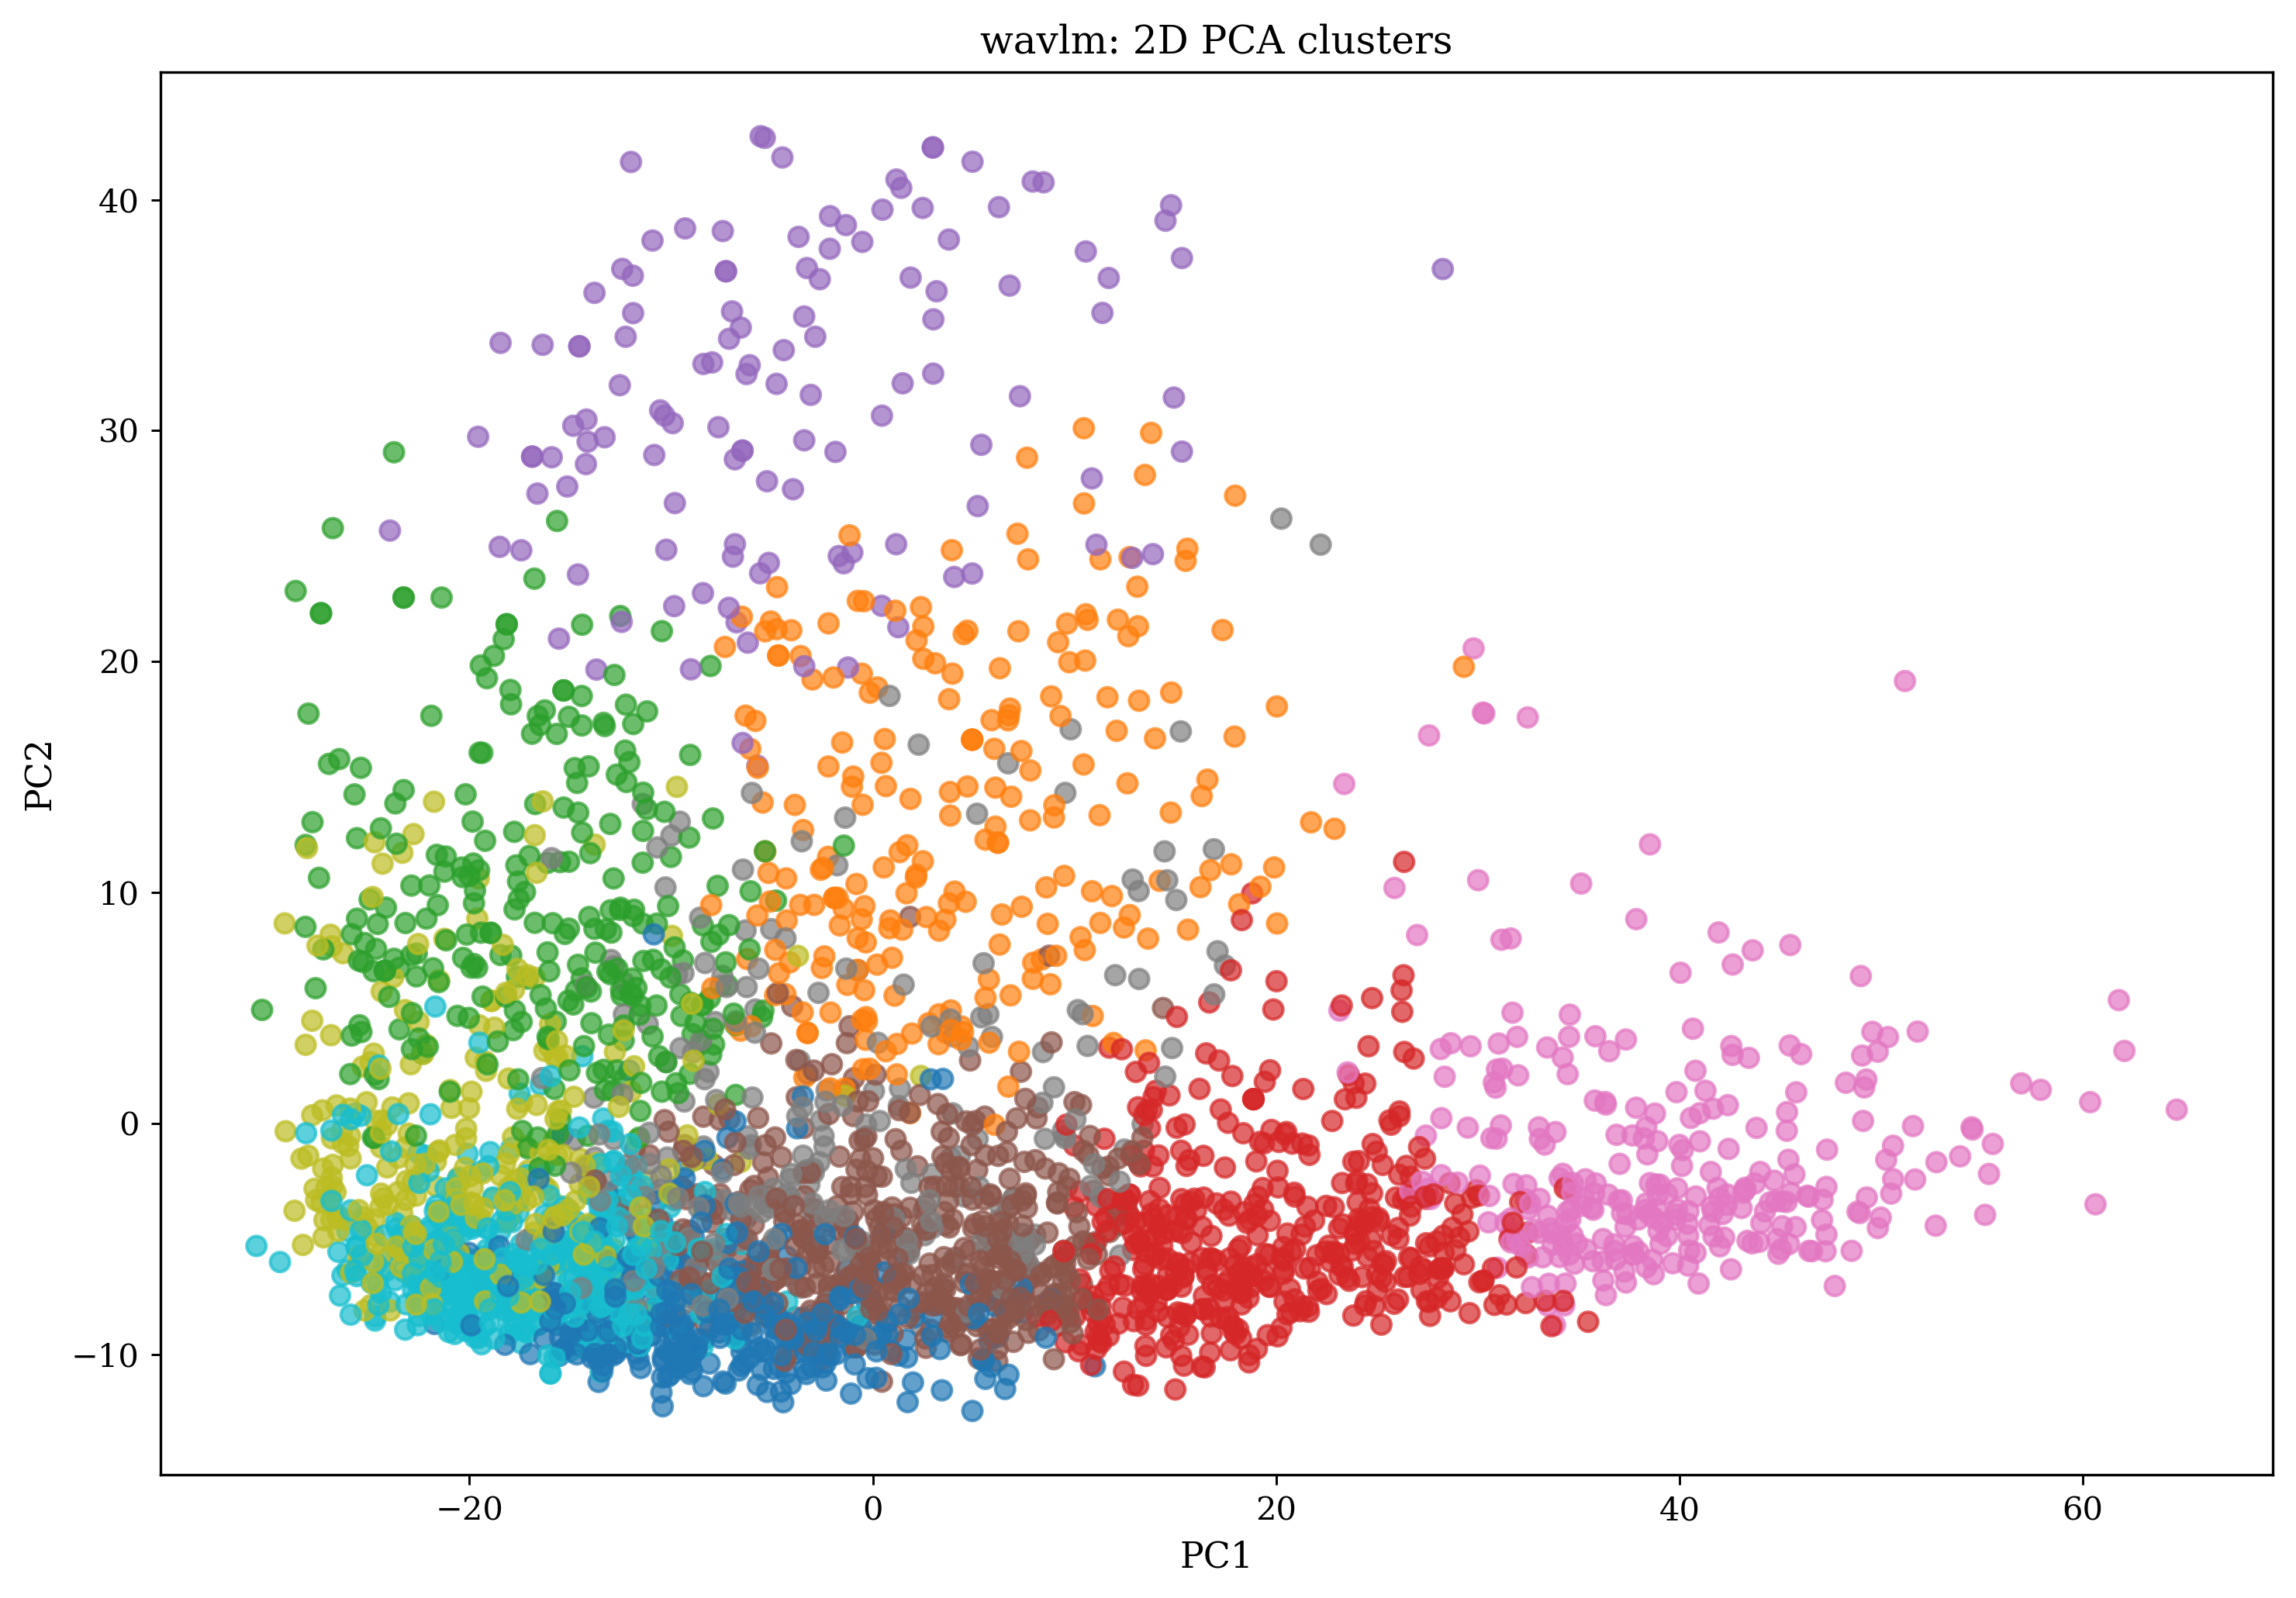

In [49]:
tuning_pipeline_driver()
plotting_pipeline_driver()
metadata_evaluation_driver()